Quantum Computing vs. Classical Computing for Pricing Options
===============================================================
This project intends to demonstrate the advantages of pricing options using a quantum computing approach rather than classical computing. 

For quantum computing, the demo will utilize qiskit's implementation. For classical, both a monte carlo and a black-scholes implementation will be used to price the options.

In [120]:
import numpy as np
import matplotlib.pyplot as plt
from math import log, pi, exp, sqrt
from scipy.stats import norm

np.random.seed(42)
plt.rcParams['figure.figsize'] = (10, 6)

In [121]:
#Here we are creating parameters for the derivative we are trying to model. In a real world scenario, the real stock information could be substituted here.

stock_price = 1000 #starting price of the stock ticker is $100
expiration = 1/12 #this means 1 month
riskFreeRate = 0.04 #risk free rate is a measure of "opportunity cost." For example, you could choose to invest your money in bonds instead for a safer return of ~4%. 
                    #it is important to discount for this cost because you want an investment that is more profitable than your risk free rate
sigma = 0.2 #volatility of the stock. This is a measure of how much the stock price fluctuates. The higher the volatility, the more the stock price fluctuates.
strike_price = 1020

simulation_count = 5000
trading_days = 21 #number of trading days in a month (average)

Black Scholes Option Pricing
----------------------------
The Black Scholes Model is a model that theoretically prices options. It is based on the following assumptions:
- The stock price follows a geometric brownian motion
- The stock pays no dividends
- The risk-free rate and volatility of the underlying asset are known and constant
- The returns on the stock are normally distributed

For the purpose of this project. The Black Scholes Model will estimate the theoretical "perfect" price of the option. We can use it to determine the accuracy of our models. However, the Black Scholes model can only accurately price "European" call and put options. Using a monte carlo approach, we can price options with more complicated payoff functions, such as "American" options.

Code used from: https://medium.com/swlh/calculating-option-premiums-using-the-black-scholes-model-in-python-e9ed227afbee

The Black Scholes Model uses the following formula to price call options:

## $$ C = N(d_1)S_t - N(d_2) K e^{-rt} $$ ##
$$\text{where } d_1 = \frac{ln{\frac{S_T}{K} + (r+\frac{\sigma^2}{2})t}}{\sigma \sqrt{t}}$$
$$\text{where } d_2 = d_1 - \sigma \sqrt{t}$$

And for pricing put options:
## $$ P = N(-d_2) K e^{-rT} - N(-d_1) S_t $$ ##
$$ d_1 \text{ and } d_2 \text{ remain unchanged}$$

In [122]:
def d1(S,K,T,r,sigma):
    return (log(S/K)+(r+sigma**2/2.)*T)/(sigma*sqrt(T))
def d2(S,K,T,r,sigma):
    return d1(S,K,T,r,sigma) - sigma*sqrt(T)

#S is the price of the stock, K is strike price, T is the time to expiration in years, r is the risk free rate, sigma is the volatility of the stock

In [151]:
def bs_call(S,K,T,r,sigma):
    return S*norm.cdf(d1(S,K,T,r,sigma))-K*exp(-r*T)*norm.cdf(d2(S,K,T,r,sigma))
  
def bs_put(S,K,T,r,sigma):
    return norm.cdf(-d2(S,K,T,r,sigma))*K*exp(-r*T)-norm.cdf(-d1(S,K,T,r,sigma))*S

In [152]:
call_value = bs_call(stock_price, strike_price, expiration, riskFreeRate, sigma)
put_value = bs_put(stock_price, strike_price, expiration, riskFreeRate, sigma)
call_value, put_value

(15.856244458231743, 32.46190483384555)

Classical Computing Monte Carlo Simulation
------------------------------------------
Implementation derived from: https://github.com/rbhatia46/Options-Pricing-Monte-Carlo.
A monte carlo simulation will use the principles in geometric brownian motion to price an option by simulating thousands of random price paths for the option. The average of these price paths discounted to the present will be the price of the option.

Geometric brownian motion for a stock price is defined as:
## $$S_t = S_0 e^{(\mu - \frac{\sigma^2}{2})t + \sigma \epsilon \sqrt{t}}$$ ##

Where $S_t$ is the stock price at time t, $S_0$ is the stock price at the time of analysis (time step 0), and $\epsilon$ is a random variable drawn from a normal distribution with mean 0 and standard deviation 1. In the exponent, the term $\mu - \frac{\sigma^2}{2}$ is the drift of the stock price, which accounts for the discount in the value of the option over time due to the aforementioned risk free rate, and $\sigma \epsilon \sqrt{t}$ accounts for the volatility of the stock (which is in the $\epsilon$ term) and is multiplied by the square root of t because standard deviation varies by the square root of time.

In [139]:
t = expiration / trading_days #number of fractional timesteps.
drift = (riskFreeRate - sigma**2 / 2) * t #expected return - volatility
epsilon = np.random.normal(0, 1, (simulation_count, trading_days))
a = sigma * np.sqrt(t)

In [140]:
#in order to carry out all the simulations at once, we will use a matrix of random numbers. This is a common technique in Monte Carlo simulations.
prices = np.zeros((simulation_count, trading_days))
prices

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [141]:
prices[:, 0] = stock_price
for timestep in range (1, trading_days):
    prices[:, timestep] = prices[:, timestep - 1] * np.exp(drift + a * epsilon[:, timestep])

In [142]:
prices

array([[1000.        , 1003.39062949, 1006.39900303, ..., 1034.76108423,
        1022.75459929, 1030.62879769],
       [1000.        , 1001.91646252,  978.69797238, ..., 1046.42038246,
        1031.22830393, 1035.54981227],
       [1000.        , 1000.82792125,  993.77063331, ...,  883.13986726,
         875.94111554,  890.56474737],
       ...,
       [1000.        ,  981.71842797,  987.75650274, ...,  966.65841219,
         952.35497736,  959.10796156],
       [1000.        , 1012.02822657, 1039.12385084, ...,  973.9545276 ,
         983.69857764,  974.14764914],
       [1000.        , 1015.13104848, 1026.42694486, ..., 1016.81730847,
        1004.99041566,  992.87189264]])

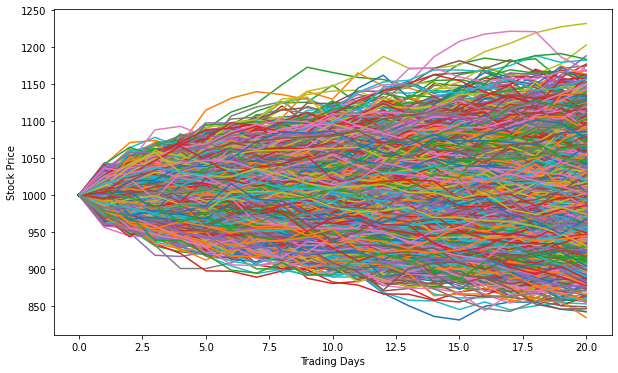

In [143]:
#plot each price path as a line
for i in range (simulation_count):
    plt.plot(prices[i, :])
plt.xlabel('Trading Days')
plt.ylabel('Stock Price')
plt.ticklabel_format(style='plain')
plt.show()

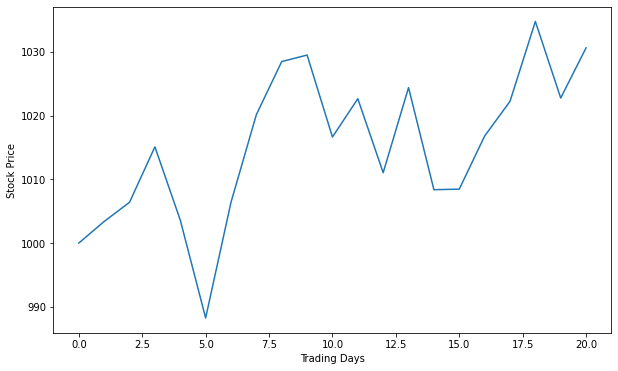

In [144]:
#show one path (the first one)
plt.plot(prices[0, :])
plt.xlabel('Trading Days')
plt.ylabel('Stock Price')
plt.ticklabel_format(style='plain')
plt.show()

Now that we have the random paths simulated, it is time to calculate the value of the option by aggregating all of the paths. The value of the call options can be measured as $max(S_t - K, 0)$, where $S_t$ is the stock price at time t, and K is the strike price of the option. The value of the put option can be measured as $max(K - S_t, 0)$, where $S_t$ is the stock price at time t, and K is the strike price of the option. The value of the option is then the average of all of these values discounted to the present. The reason we take the max between the difference and 0 is because options are, by nature of their name, *optional*, which means that any options losing money will simply not be exercised

In [145]:
callPayoffs = np.maximum(prices[:, -1] - strike_price, 0)
callPayoffs

array([10.62879769, 15.54981227,  0.        , ...,  0.        ,
        0.        ,  0.        ])

In [146]:
putPayoffs = np.maximum(strike_price - prices[:, -1], 0)
putPayoffs

array([  0.        ,   0.        , 129.43525263, ...,  60.89203844,
        45.85235086,  27.12810736])

In [153]:
callValue = np.mean(callPayoffs) * np.exp(-riskFreeRate * expiration) #discounted value of the call option
putValue = np.mean(putPayoffs) * np.exp(-riskFreeRate * expiration) #discounted value of the put option
callValue, putValue

(15.399175110071665, 32.38150920056305)